# Expectation maximization algorithm for a Gaussian mixture model

To compute a maximum likelihood fit for a mixture of Gaussians model of the Old Faithful dataset using the expectation maximization algorithm.

The likelihood for a mixture model is defined as: $p(x_i|\theta) = \sum_k p(x_i, z_i = k | \theta) = \sum_k p(x_i| z_i = k, \theta) p(z_i=k|\theta) $ where $x_i$ is the feature vector of the $i$th data point, $z_i$ is a latent (unobserved) variable and $\theta$ is a parameter vector. $k$ is an index which labels each base distribution, $k=1,\dots,K$. 

For a Gaussian mixture model, each 'base distribution' $p(x_i| z_i = k, \theta) = \mathcal{N}(\mu_k,\Sigma_k)$, where $\mu_k$ is the mean and $\Sigma_k$ is the covariance matrix of each multivariate Gaussian in the mixture model.

Based on Ch11 of Machine Learning: A Probabilistic Perspective (Kevin Murphy)

Author: Juvid Aryaman


In [1]:
import numpy as np
import pandas as pd
import utls
from os.path import join
import matplotlib.pyplot as plt
%reload_ext autoreload
%autoreload 2
%matplotlib inline


In [2]:
utls.reset_plots()

In [3]:
from scipy.stats import multivariate_normal

## Import and transform data

In [4]:
data_dir = '../Data/'

In [5]:
data = pd.read_csv(join(data_dir,'faithful.csv'), delimiter=',')
data.columns=['d','w']

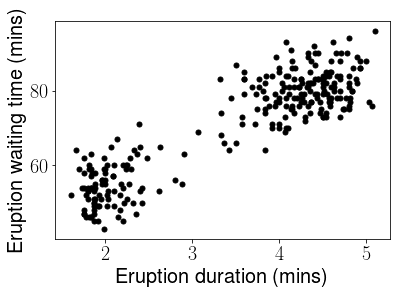

In [6]:
fig, ax = plt.subplots(1,1)
ax.plot(data['d'],data['w'],'.k');
ax.set_xlabel('Eruption duration (mins)');
ax.set_ylabel('Eruption waiting time (mins)');

The data clearly shows the existence of two clusters (bottom left and top right), so we will use $K=2$. Our aim is to model the data as a mixture of two bivariate Gaussians, where every data point $x_i$ possesses a latent variable $z_i$ which is the identity of the Gaussian which it belongs to. We will seek a maximum-likelihood fit.

First, we normalize the data. In practice, this improves the convergence of the algorithm.

In [7]:
# z-transform data
data['d'] = (data['d'] - data['d'].mean())/data['d'].std(ddof=1)
data['w'] = (data['w'] - data['w'].mean())/data['w'].std(ddof=1)
data.head()

,d,w
0,0.098318,0.596025
1,-1.478733,-1.242890
2,-0.135612,0.228242
3,-1.055558,-0.654437
4,0.915755,1.037364


## Definitions for the EM algorithm

The EM algorithm proceeds in two steps. Let $l_c(\theta) = \sum_{i=1}^N \log p( x_i, z_i| \theta)$ be the likelihood of observing the data *and* the latent variables: this is called the 'complete data log likelihood'.

1. Compute the (sufficient statistics of) the mean of $l_c(\theta)$ over the latent variables $z$, assuming values of $\theta$ at the previous time step. Call this $Q(\theta,\theta^{t-1}) = \mathbb{E}_{z|x,\theta^{t-1}}[l_c(\theta)|\mathcal{D},\theta^{t-1}]$
2. Optimize the value of $Q(\theta,\theta^{t-1})$ with respect to $\theta$

Repeat until convergence.

It turns out that for (1), the sufficient statistic of $Q(\theta,\theta^{t-1})$ is called the **responsibility**

$$r_{ik}:=p(z_i=k|x_i,\theta^{t-1}) = \frac{\pi_k p(x_i|z_i=k,\theta_k^{t-1})}{\sum_{k'}\pi_{k'}p(x_i|z_i=k',\theta_{k'}^{t-1})}$$

where $\pi_k=p(z_i=k|\theta)$ is the mixing weight. $r_{ik}$ is simply the probability that data point $i$ is in cluster $k$.

In [8]:
def compute_expected_sufficient_statistic(data,params):
    """
    Compute the responsibility cluster k takes for each data point
    """
    
    lik0 = multivariate_normal.pdf(data,mean=params['mu0'], cov=params['sig0'])
    lik1 = multivariate_normal.pdf(data,mean=params['mu1'], cov=params['sig1'])
    
    rik=np.array(zip(lik0, lik1))

    den = rik[:,0]*params['pi0'] + rik[:,1]*params['pi1']

    rik[:,0] = rik[:,0]*params['pi0']/den
    rik[:,1] = rik[:,1]*params['pi1']/den
    
    return rik # weighted probability data point xi belongs to cluster k
    
    

Use `np.einsum` to implement tensor operations for expectation maximization, which uses the Einstein summation convention. For example, for normal matrix multiplication
$$A_{ij}=\sum_j B_{ij}C_{jk}$$
may be written as `np.einsum('ij,jk->ik',A,B)`

In [9]:
A = np.array([[1,2],[2,3]]); B = np.array([[4,2],[1,1]])
np.einsum('ij,jk->ik',A,B) == np.dot(A,B)

array([[ True,  True],
       [ True,  True]], dtype=bool)

## Perform Expectation Maximization

In [10]:
# Initialise parameter guess
nclusters = 2
c_guess = np.eye(nclusters)
params = {'pi0':0.5,'pi1':0.5,'mu0':np.array([-1,1]),'mu1':np.array([1,-1]),'sig0':c_guess,'sig1':c_guess}

params_ic = params.copy()

N = len(data)

n_iter = 50

d = data.as_matrix()

In [11]:
rik_all = np.zeros((len(data),2,n_iter))
for i in range(n_iter):
    
    if i % 10 == 0:
        print(i)
    
    # 1. Expectation
    # Compute expected sufficient statistics
    # i.e. probability data point i is in cluster k given parameters

    rik = compute_expected_sufficient_statistic(data,params) # (data index, probabilities)
    rik_all[:,:,i] = rik
    
    # 2. Maximization
    # Optimize expected complete data log likelihood w.r.t. parameters
    rk = rik.sum(axis=0) # sum over data (rows)
    
    for k in range(nclusters): 
        params['pi{}'.format(k)] = np.sum(rik[:,k])/N      
    
    means = np.dot(rik.T,d)/rk[:,None] # each row is the location of the mean of the clusterb
    
    # an array of covariance matrices
    covs = np.einsum('il,im,ik->klm',d,d,rik)/rk[:,None,None] - np.einsum('ij,ik->ijk',means, means) 
    
    for k in range(nclusters):     
        # Store params
        params['mu{}'.format(k)] = means[k,:]                
        params['sig{}'.format(k)] = covs[k]
        
        
    

0
10
20
30
40


In [14]:
np.einsum('ij,ik->ijk',means, means) 

array([[[ 1.61688013,  1.53559826],
        [ 1.53559826,  1.45840249]],

       [[ 0.49365853,  0.46884192],
        [ 0.46884192,  0.44527286]]])

In [18]:
np.einsum('j,k->jk',means[0],means[0])

array([[ 1.61688013,  1.53559826],
       [ 1.53559826,  1.45840249]])

In [15]:
np.outer(means[0],means[0])

array([[ 1.61688013,  1.53559826],
       [ 1.53559826,  1.45840249]])

In [12]:
cmap = plt.cm.coolwarm

Plot the data colored by the probability that they belong to a particular cluster

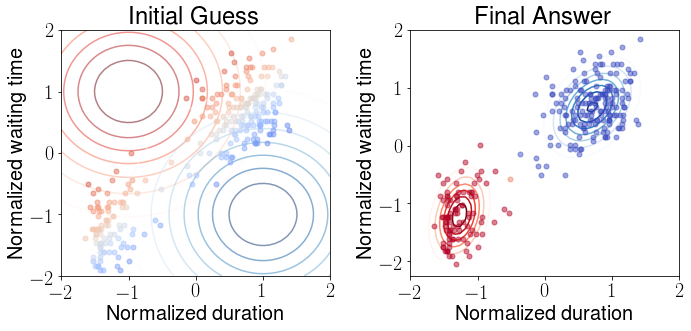

In [13]:
X = np.linspace(-2,2)
Y = np.linspace(-2,2)
X, Y = np.meshgrid(X,Y)
pos = np.empty(X.shape + (2,))
pos[:, :, 0] = X
pos[:, :, 1] = Y
Z0_i = utls.multivariate_gaussian(pos, mu=params_ic['mu0'], Sigma=params_ic['sig0'])
Z0_f = utls.multivariate_gaussian(pos, mu=params['mu0'], Sigma=params['sig0'])
Z1_i = utls.multivariate_gaussian(pos, mu=params_ic['mu1'], Sigma=params_ic['sig1'])
Z1_f = utls.multivariate_gaussian(pos, mu=params['mu1'], Sigma=params['sig1'])





rik_orig = compute_expected_sufficient_statistic(data,params_ic)

fig,axs = plt.subplots(1,2, figsize=(2*5,5))

ax = axs[0]
for row in data.iterrows():
    i = row[0]
    d = row[1]
    ax.plot(d['d'],d['w'],'.',color=cmap(int(round(rik_orig[i,0]*cmap.N))),alpha=0.5)

ax.contour(X, Y, Z0_i, cmap='Reds', alpha=0.5)
ax.contour(X, Y, Z1_i, cmap='Blues', alpha=0.5)

ax.set_title('Initial Guess');
ax.set_xlabel('Normalized duration');
ax.set_ylabel('Normalized waiting time');
ax.set_xlim([-2,2]);
ax.set_ylim([-2,2]);

ax = axs[1]
for row in data.iterrows():
    i = row[0]
    d = row[1]
    ax.plot(d['d'],d['w'],'.',color=cmap(int(round(rik[i,0]*cmap.N))),alpha=0.5)
ax.set_title('Final Answer');
ax.set_xlabel('Normalized duration');
ax.set_ylabel('Normalized waiting time');

ax.contour(X, Y, Z0_f, cmap='Reds')
ax.contour(X, Y, Z1_f, cmap='Blues')



plt.tight_layout()